In [35]:
import re
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline
#from StringIO import StringIO #for Python 2
import seaborn as sb
from io import StringIO #for Python 3
import csv
import json
from pandas.io.json import json_normalize
#from flatten_json import flatten
from lxml import etree
from xml.etree import ElementTree as ET

import scipy.stats as st
import zipfile
import glob
import geocoder as gc

import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
sales_files = glob.glob("Annualized_20Rolling_20Sales_20Update"+"/*.xls") #list of paths matching pathname pattern for sales data files.

df_sales = pd.DataFrame()

for i in range(len(sales_files)):
    df = pd.read_excel(sales_files[i],skiprows=4,converters={'BOROUGH':str, 'NEIGHBORHOOD':str, 'BUILDING CLASS CATEGORY':str,
       'TAX CLASS AT PRESENT':str, 'BLOCK':str, 'LOT':str, 'EASE-MENT':str,
       'BUILDING CLASS AT PRESENT':str, 'ADDRESS':str, 'APARTMENT NUMBER':str, 'ZIP CODE':str,
       'RESIDENTIAL UNITS':np.int64, 'COMMERCIAL UNITS':np.int64, 'TOTAL UNITS':np.int64,
       'LAND SQUARE FEET':np.int64, 'GROSS SQUARE FEET':np.int64, 'YEAR BUILT':np.int64,
       'TAX CLASS AT TIME OF SALE':str, 'BUILDING CLASS AT TIME OF SALE':str,
       'SALE PRICE':np.float64, 'SALE DATE':pd.tslib.Timestamp})
    df_sales = df_sales.append(df)


print(df_sales.dtypes)
               


BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                     object
LOT                                       object
EASE-MENT                                 object
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                  object
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                           int64
GROSS SQUARE FEET                          int64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE                 object
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                               float64
SALE DATE           

**Data Wrangling**

In [3]:
df_sales.head() #Data review

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,03 THREE FAMILY HOMES,1,377,10,,C0,356 EAST 8TH STREET,,...,3,0,3,1804,2928,1899,1,C0,0.0,2012-07-09
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,375,62,,C4,715 EAST 5TH STREET,,...,20,0,20,2426,9345,1900,2,C4,3650000.0,2012-09-06
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,30,,C4,274 EAST SEVENTH STREET,,...,13,0,13,2726,13002,1910,2,C4,895250.0,2012-10-25
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,377,52,,C2,271 EAST 7TH STREET,,...,5,0,5,2169,3728,1900,2,C2,0.0,2012-02-16
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,387,157,,C1,619 EAST 5TH STREET,,...,40,0,40,4853,25200,1900,2,C1,10800000.0,2012-07-13


In [124]:
#reading crime data
df_crime = pd.read_csv("NYPD_Complaint_Data_Historic.csv",dtype = {'CMPLNT_NUM' : str, 'CMPLNT_FR_DT' : pd.tslib.Timestamp, 
                        'CMPLNT_FR_TM' : pd.tslib.Timestamp, 'CMPLNT_TO_DT' : pd.tslib.Timestamp,
                        'CMPLNT_TO_TM' : pd.tslib.Timestamp, 'RPT_DT' : pd.tslib.Timestamp, 'KY_CD' : str, 
                        'OFNS_DESC' : str, 'PD_CD' : str, 'PD_DESC' : str,'CRM_ATPT_CPTD_CD' : str, 
                        'LAW_CAT_CD' : str, 'JURIS_DESC' : str, 'BORO_NM' : str,'ADDR_PCT_CD' : str, 
                        'LOC_OF_OCCUR_DESC' : str, 'PREM_TYP_DESC' : str, 'PARKS_NM' : str,'HADEVELOPT' : str, 
                        'X_COORD_CD' : str, 'Y_COORD_CD' : str, 'Latitude' : str, 'Longitude' : str,'Lat_Lon' : str})

df_crime.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103,OUTSIDE,NaN,NaN,NaN,1043991,193406,40.697338138,-73.784556739,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503,"CONTROLLED SUBSTANCE,INTENT TO",...,28,NaN,OTHER,NaN,NaN,999463,231690,40.802606608,-73.945051911,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,...,105,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183,177862,40.654549444,-73.726338791,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,...,13,FRONT OF,OTHER,NaN,NaN,987606,208148,40.7380024,-73.98789129,"(40.7380024, -73.98789129)"


In [5]:
df_crime.dtypes

CMPLNT_NUM           object
CMPLNT_FR_DT         object
CMPLNT_FR_TM         object
CMPLNT_TO_DT         object
CMPLNT_TO_TM         object
RPT_DT               object
KY_CD                object
OFNS_DESC            object
PD_CD                object
PD_DESC              object
CRM_ATPT_CPTD_CD     object
LAW_CAT_CD           object
JURIS_DESC           object
BORO_NM              object
ADDR_PCT_CD          object
LOC_OF_OCCUR_DESC    object
PREM_TYP_DESC        object
PARKS_NM             object
HADEVELOPT           object
X_COORD_CD           object
Y_COORD_CD           object
Latitude             object
Longitude            object
Lat_Lon              object
dtype: object

In [6]:
#comparing data min max dates for available data
print(len(df_sales),'\n','min:',min(df_sales['SALE DATE']),'max:',max(df_sales['SALE DATE']))
print(len(df_crime),'\n','min:',min(df_crime['RPT_DT']),'max:',max(df_crime['RPT_DT']))

1254034 
 min: 2003-01-01 00:00:00 max: 2015-12-31 00:00:00
5580035 
 min: 01/01/2006 max: 12/31/2016


In [10]:
#looking for missing data values in data
print("SALE DATE: null values: \n",pd.isnull(df_sales["SALE DATE"]).value_counts())
print("CRIME DATA/RPT_DT: null values: \n",pd.isnull(df_crime["RPT_DT"]).value_counts())
print("CRIME DATA/CMPLNT_FR_DT: null values: \n",pd.isnull(df_crime["CMPLNT_FR_DT"]).value_counts())
print("CRIME DATA/CMPLNT_TO_DT: null values: \n",pd.isnull(df_crime["CMPLNT_TO_DT"]).value_counts())

SALE DATE: null values: 
 False    1254034
Name: SALE DATE, dtype: int64
CRIME DATA/RPT_DT: null values: 
 False    5580035
Name: RPT_DT, dtype: int64
CRIME DATA/CMPLNT_FR_DT: null values: 
 False    5579380
True         655
Name: CMPLNT_FR_DT, dtype: int64
CRIME DATA/CMPLNT_TO_DT: null values: 
 False    4107249
True     1472786
Name: CMPLNT_TO_DT, dtype: int64


In [125]:
#Filling missing data values
x = pd.isnull(df_crime["CMPLNT_FR_DT"])
y = pd.isnull(df_crime["CMPLNT_TO_DT"])

print("Before filling missing values:")
print(df_crime[["RPT_DT","CMPLNT_FR_DT","CMPLNT_TO_DT"]][x].head())
print(df_crime[["RPT_DT","CMPLNT_FR_DT","CMPLNT_TO_DT"]][y].head())

print("Filling missing values with corresponding row valus from RPT_DT")

df_crime["CMPLNT_FR_DT"] = df_crime["CMPLNT_FR_DT"].fillna(df_crime["RPT_DT"])
df_crime["CMPLNT_TO_DT"] = df_crime["CMPLNT_TO_DT"].fillna(df_crime["RPT_DT"])

print("After filling missing values:")
print(df_crime[["RPT_DT","CMPLNT_FR_DT","CMPLNT_TO_DT"]][x].head())
print(df_crime[["RPT_DT","CMPLNT_FR_DT","CMPLNT_TO_DT"]][y].head())


Before filling missing values:
            RPT_DT CMPLNT_FR_DT CMPLNT_TO_DT
149911  09/09/2015          NaN   09/08/2015
151388  09/08/2015          NaN          NaN
175384  08/22/2015          NaN          NaN
193200  08/10/2015          NaN          NaN
223738  07/20/2015          NaN   07/20/2015
       RPT_DT CMPLNT_FR_DT CMPLNT_TO_DT
0  12/31/2015   12/31/2015          NaN
1  12/31/2015   12/31/2015          NaN
2  12/31/2015   12/31/2015          NaN
3  12/31/2015   12/31/2015          NaN
6  12/31/2015   12/31/2015          NaN
Filling missing values with corresponding row valus from RPT_DT
After filling missing values:
            RPT_DT CMPLNT_FR_DT CMPLNT_TO_DT
149911  09/09/2015   09/09/2015   09/08/2015
151388  09/08/2015   09/08/2015   09/08/2015
175384  08/22/2015   08/22/2015   08/22/2015
193200  08/10/2015   08/10/2015   08/10/2015
223738  07/20/2015   07/20/2015   07/20/2015
       RPT_DT CMPLNT_FR_DT CMPLNT_TO_DT
0  12/31/2015   12/31/2015   12/31/2015
1  12/31/2015  

In [12]:
#verifying missing data values post corrections
print("CRIME DATA/CMPLNT_FR_DT: null values: \n",pd.isnull(df_crime["CMPLNT_FR_DT"]).value_counts())
print("CRIME DATA/CMPLNT_TO_DT: null values: \n",pd.isnull(df_crime["CMPLNT_TO_DT"]).value_counts())


CRIME DATA/CMPLNT_FR_DT: null values: 
 False    5580035
Name: CMPLNT_FR_DT, dtype: int64
CRIME DATA/CMPLNT_TO_DT: null values: 
 False    5580035
Name: CMPLNT_TO_DT, dtype: int64


In [146]:
#correcting years 1015,1016 and 1026 in 'CMPLNT_FR_DT'. it is evident from RPT date that these years are typo errors in data.
pat1 = re.compile('(?P<one>\d\d/\d\d)(?P<two>/101)(?P<three>\d)')
pat2 = re.compile('(?P<one>\d\d/\d\d)(?P<two>/102)(?P<three>\d)')

repl1 = lambda x: pat1.sub(r'\g<1>/201\g<3>',x)
repl2 = lambda x: pat2.sub(r'\g<1>/201\g<3>',x)

index1 = df_crime[df_crime['CMPLNT_FR_DT'].str.contains(pat1) == True].index
index2 = df_crime[df_crime['CMPLNT_FR_DT'].str.contains(pat2) == True].index

for i in index1:
    df_crime['CMPLNT_FR_DT'][i] = repl1(df_crime['CMPLNT_FR_DT'][i])
    
    
for i in index2:
    df_crime['CMPLNT_FR_DT'][i] = repl2(df_crime['CMPLNT_FR_DT'][i])
    


In [141]:
#validating data corrections
#df_crime[df_crime['CMPLNT_FR_DT'].str.contains(pat1) == True]
df_crime[df_crime['CMPLNT_FR_DT'].str.contains(pat2) == True]

/home/mahesh_yerra/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon


In [150]:
#data type converstion to dates-time
df_crime['CMPLNT_FR_DT'] = pd.to_datetime(df_crime['CMPLNT_FR_DT'])
df_crime['CMPLNT_TO_DT'] = pd.to_datetime(df_crime['CMPLNT_TO_DT'])
df_crime['RPT_DT'] = pd.to_datetime(df_crime['RPT_DT'])

In [151]:
df_crime.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,2015-12-31,23:45:00,2015-12-31,NaN,2015-12-31,113,FORGERY,729,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)"
1,153401121,2015-12-31,23:36:00,2015-12-31,NaN,2015-12-31,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103,OUTSIDE,NaN,NaN,NaN,1043991,193406,40.697338138,-73.784556739,"(40.697338138, -73.784556739)"
2,569369778,2015-12-31,23:30:00,2015-12-31,NaN,2015-12-31,117,DANGEROUS DRUGS,503,"CONTROLLED SUBSTANCE,INTENT TO",...,28,NaN,OTHER,NaN,NaN,999463,231690,40.802606608,-73.945051911,"(40.802606608, -73.945051911)"
3,968417082,2015-12-31,23:30:00,2015-12-31,NaN,2015-12-31,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,...,105,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183,177862,40.654549444,-73.726338791,"(40.654549444, -73.726338791)"
4,641637920,2015-12-31,23:25:00,2015-12-31,23:30:00,2015-12-31,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,...,13,FRONT OF,OTHER,NaN,NaN,987606,208148,40.7380024,-73.98789129,"(40.7380024, -73.98789129)"


In [152]:
#Since, crime_data does not have zip code information, 
#constructing data frame of lat_lon with crime count for each lat_lon coordinates
geo_codes = df_crime.Lat_Lon.value_counts()
geo_codes_zip = pd.DataFrame({'crime_count':geo_codes.values, 'lat_lon':geo_codes.index})
geo_codes_zip.head()

,crime_count,lat_lon
0,18363,"(40.750430768, -73.989282176)"
1,6429,"(40.791151867, -73.884371919)"
2,6171,"(40.710093847, -74.01060963)"
3,5002,"(40.756266207, -73.990501248)"
4,4988,"(40.733926841, -73.871582398)"


In [153]:
geo_codes_zip['zip'] = '0' #adding new column for zip-code
geo_codes_zip.head()

,crime_count,lat_lon,zip
0,18363,"(40.750430768, -73.989282176)",0
1,6429,"(40.791151867, -73.884371919)",0
2,6171,"(40.710093847, -74.01060963)",0
3,5002,"(40.756266207, -73.990501248)",0
4,4988,"(40.733926841, -73.871582398)",0


In [158]:
#Challenge:cannot extract reverse geocoding from google API for more than 100,000 records in a day
#work around: breaking geo_codes_zip dataframe into 2 smaller data frames
#This is a very long process, as the open-source interfaces time-out every 10 minutes.

geo_codes_zip_1 = geo_codes_zip[0:90000]
geo_codes_zip_2 = geo_codes_zip[90000:]

print('geo_codes_zip1:',len(geo_codes_zip_1))
print('geo_codes_zip2:',len(geo_codes_zip_2))

geo_codes_zip1: 90000
geo_codes_zip2: 23885


In [96]:
geo_codes_zip_1.to_csv('geo_codes_1.csv')
geo_codes_zip_2.to_csv('geo_codes_2.csv')

In [628]:
geo_index = geo_codes_zip_1[(geo_codes_zip_1.zip == '0') | (pd.notnull(geo_codes_zip_1.zip) == False) ].index

'''
#using google API for for extracting zip codes
for i in geo_index:
    zip_code = gc.google(geo_codes_zip_1.lat_lon[i],method='reverse').postal
    geo_codes_zip_1.zip[i] = zip_code
'''

#using OSM(Open Street Maps) API for for extracting zip codes
for i in geo_index:
    zip_code = gc.osm(geo_codes_zip_1.lat_lon[i],method='reverse').postal
    geo_codes_zip_1.zip[i] = zip_code

geo_codes_zip_1.to_csv('geo_codes_zip_1.csv')

geocoded_index = geo_codes_zip_1[(geo_codes_zip_1.zip != '0') & (pd.notnull(geo_codes_zip_1.zip)) ].index

/home/mahesh_yerra/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mahesh_yerra/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [630]:
#geo_codes_zip_1.iloc[geo_index,]
geo_codes_zip_1.iloc[geocoded_index,]

,crime_count,lat_lon,zip
0,18363,"(40.750430768, -73.989282176)",10001
1,6429,"(40.791151867, -73.884371919)",11370
2,6171,"(40.710093847, -74.01060963)",10007
3,5002,"(40.756266207, -73.990501248)",10018
4,4988,"(40.733926841, -73.871582398)",11373
5,4984,"(40.804384046, -73.937421669)",10035
6,4615,"(40.610717129, -73.920985283)",11234
7,4604,"(40.651698159, -73.868446756)",11239
8,4450,"(40.684461543, -73.97775121)",11217
9,4449,"(40.749121191, -73.986167723)",10001


In [ ]:
geo_index = geo_codes_zip_2[(geo_codes_zip_2.zip == '0') | (pd.notnull(geo_codes_zip_2.zip) == False) ].index

#using google API for for extracting zip codes
for i in geo_index:
    zip_code = gc.google(geo_codes_zip_2.lat_lon[i],method='reverse').postal
    geo_codes_zip_2.zip[i] = zip_code

'''
#using OSM(Open Street Maps) API for for extracting zip codes
for i in geo_index:
    zip_code = gc.osm(geo_codes_zip_2.lat_lon[i],method='reverse').postal
    geo_codes_zip_1.zip[i] = zip_code
'''
geo_codes_zip_2.to_csv('geo_codes_zip_2.csv')


geocoded_index = geo_codes_zip_2[(geo_codes_zip_2.zip != '0') & (pd.notnull(geo_codes_zip_2.zip)) ].index

In [ ]:
geo_codes_zip_2.iloc[geo_index,]
geo_codes_zip_2.iloc[geocoded_index,]

In [170]:
#reading saved zip_code files back from local drive
geo_codes_zip_1 = pd.read_csv('geo_codes_zip_1.csv',usecols=[0,1,2,3],index_col=0)
geo_codes_zip_1.head()

,crime_count,lat_lon,zip
0,18363,"(40.750430768, -73.989282176)",10001
1,6429,"(40.791151867, -73.884371919)",11370
2,6171,"(40.710093847, -74.01060963)",10007
3,5002,"(40.756266207, -73.990501248)",10018
4,4988,"(40.733926841, -73.871582398)",11373


In [171]:
geo_codes_zip_2 = pd.read_csv('geo_codes_zip_2.csv',usecols=[0,1,2,3],index_col=0)
geo_codes_zip_2.head()

,crime_count,lat_lon,zip
90000,4,"(40.615018575, -73.910246639)",11234
90001,4,"(40.709622031, -73.993122948)",7307
90002,4,"(40.716792507, -73.880345234)",11379
90003,4,"(40.727756904, -73.811878927)",11367
90004,4,"(40.703542344, -74.007409493)",10005


In [176]:
#appending 2 zip_code datasets
geo_codes_zip = geo_codes_zip_1.append(geo_codes_zip_2)
len(geo_codes_zip)

113885

In [184]:
#truncating crime_count from zip_code file as this count is Lat_Lon level but not at zip_code level.
#zip_code level crime count will be calculated from crime data for different periods in the past later.
geo_codes_zip.columns = ['crime_count','Lat_Lon','zip_code']
geo_codes_zip = geo_codes_zip[['Lat_Lon','zip_code']]
geo_codes_zip.head()

,Lat_Lon,zip_code
0,"(40.750430768, -73.989282176)",10001
1,"(40.791151867, -73.884371919)",11370
2,"(40.710093847, -74.01060963)",10007
3,"(40.756266207, -73.990501248)",10018
4,"(40.733926841, -73.871582398)",11373


In [186]:
#merging zip_codes with crime data on to a temp file
temp = pd.merge(df_crime,geo_codes_zip, on = 'Lat_Lon')
temp.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,zip_code
0,101109527,2015-12-31,23:45:00,2015-12-31,NaN,2015-12-31,113,FORGERY,729,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
1,163896203,2015-11-12,23:00:00,2015-11-13,NaN,2015-11-13,361,OFF. AGNST PUB ORD SENSBLTY &,639,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
2,938500214,2015-09-23,18:30:00,2015-09-23,19:00:00,2015-09-24,361,OFF. AGNST PUB ORD SENSBLTY &,639,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
3,861343822,2015-08-31,12:00:00,2015-08-31,13:00:00,2015-09-04,344,ASSAULT 3 & RELATED OFFENSES,114,OBSTR BREATH/CIRCUL,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
4,375862763,2015-08-09,04:00:00,2015-08-09,NaN,2015-08-09,106,FELONY ASSAULT,109,"ASSAULT 2,1,UNCLASSIFIED",...,INSIDE,STREET,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456


In [189]:
#assigining crime data with zip codes to original crime file.
df_crime = temp
df_crime.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,zip_code
0,101109527,2015-12-31,23:45:00,2015-12-31,NaN,2015-12-31,113,FORGERY,729,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
1,163896203,2015-11-12,23:00:00,2015-11-13,NaN,2015-11-13,361,OFF. AGNST PUB ORD SENSBLTY &,639,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
2,938500214,2015-09-23,18:30:00,2015-09-23,19:00:00,2015-09-24,361,OFF. AGNST PUB ORD SENSBLTY &,639,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
3,861343822,2015-08-31,12:00:00,2015-08-31,13:00:00,2015-09-04,344,ASSAULT 3 & RELATED OFFENSES,114,OBSTR BREATH/CIRCUL,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456
4,375862763,2015-08-09,04:00:00,2015-08-09,NaN,2015-08-09,106,FELONY ASSAULT,109,"ASSAULT 2,1,UNCLASSIFIED",...,INSIDE,STREET,NaN,NaN,1007314,241257,40.828848333,-73.916661142,"(40.828848333, -73.916661142)",10456


In [190]:
#writing dataframe to csv file in a local folder to save computations in future
df_crime.to_csv('df_crime.csv',index = False)

In [191]:
#writing dataframe to csv file in a local folder to save computations in future
df_sales.to_csv('df_sales.csv',index = False)

In [193]:
df_crime.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon', 'zip_code'],
      dtype='object')

In [4]:
#Next step: group by operations to summarise type and number of crimes each month/year at each zip_code
df_crime = pd.read_csv('df_crime.csv')
df_crime.head()

/home/mahesh_yerra/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,zip_code
0,101109527,2015-12-31,23:45:00,2015-12-31,NaN,2015-12-31,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
1,163896203,2015-11-12,23:00:00,2015-11-13,NaN,2015-11-13,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
2,938500214,2015-09-23,18:30:00,2015-09-23,19:00:00,2015-09-24,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
3,861343822,2015-08-31,12:00:00,2015-08-31,13:00:00,2015-09-04,344,ASSAULT 3 & RELATED OFFENSES,114.0,OBSTR BREATH/CIRCUL,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
4,375862763,2015-08-09,04:00:00,2015-08-09,NaN,2015-08-09,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,INSIDE,STREET,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456


In [4]:
df_sales = pd.read_csv('df_sales.csv')
df_sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,03 THREE FAMILY HOMES,1,377,10,,C0,356 EAST 8TH STREET,,...,3,0,3,1804,2928,1899,1,C0,0.0,2012-07-09
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,375,62,,C4,715 EAST 5TH STREET,,...,20,0,20,2426,9345,1900,2,C4,3650000.0,2012-09-06
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,30,,C4,274 EAST SEVENTH STREET,,...,13,0,13,2726,13002,1910,2,C4,895250.0,2012-10-25
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,377,52,,C2,271 EAST 7TH STREET,,...,5,0,5,2169,3728,1900,2,C2,0.0,2012-02-16
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,387,157,,C1,619 EAST 5TH STREET,,...,40,0,40,4853,25200,1900,2,C1,10800000.0,2012-07-13


In [5]:
#Functions for calculating crime count for each zip code for different periods in the past.

def past_crime_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code as of given date.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['RPT_DT']< date)])
    return x

def past6M_crime_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 6 months from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(6,'M')))])
    return x

def past1Y_crime_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 1 Year from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(1,'Y')))])
    return x

def past2Y_crime_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 2 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(2,'Y')))])
    return x

def past3Y_crime_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 3 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(3,'Y')))])
    return x

def past4Y_crime_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 4 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(4,'Y')))])
    return x


def past5Y_crime_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 5 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(5,'Y')))])
    return x



In [6]:
#testing function calls
print('crime count as of sale date for zip_code: %d =  %d'%(df_sales['ZIP CODE'][0],past_crime_count((df_sales['SALE DATE'][0]),df_sales['ZIP CODE'][0])))
print('crime in past 6 months of sale date for zip_code: %d =  %d'%(df_sales['ZIP CODE'][0],past6M_crime_count((df_sales['SALE DATE'][0]),df_sales['ZIP CODE'][0])))
print('crime in past 1 year of sale date for zip_code: %d =  %d'%(df_sales['ZIP CODE'][0],past1Y_crime_count((df_sales['SALE DATE'][0]),df_sales['ZIP CODE'][0])))
print('crime in past 2 years of sale date for zip_code: %d =  %d'%(df_sales['ZIP CODE'][0],past2Y_crime_count((df_sales['SALE DATE'][0]),df_sales['ZIP CODE'][0])))
print('crime in past 3 years of sale date for zip_code: %d =  %d'%(df_sales['ZIP CODE'][0],past3Y_crime_count((df_sales['SALE DATE'][0]),df_sales['ZIP CODE'][0])))
print('crime in past 4 years of sale date for zip_code: %d =  %d'%(df_sales['ZIP CODE'][0],past4Y_crime_count((df_sales['SALE DATE'][0]),df_sales['ZIP CODE'][0])))
print('crime in past 5 years of sale date for zip_code: %d =  %d'%(df_sales['ZIP CODE'][0],past5Y_crime_count((df_sales['SALE DATE'][0]),df_sales['ZIP CODE'][0])))

crime count as of sale date for zip_code: 10009 =  17278
crime in past 6 months of sale date for zip_code: 10009 =  1396
crime in past 1 year of sale date for zip_code: 10009 =  2740
crime in past 2 years of sale date for zip_code: 10009 =  5268
crime in past 3 years of sale date for zip_code: 10009 =  7778
crime in past 4 years of sale date for zip_code: 10009 =  10624
crime in past 5 years of sale date for zip_code: 10009 =  13218


In [17]:
#extracting sample of 5000 transactions from original sale data.
df_sales_sample = df_sales.sample(n=5000,random_state=9001)
df_sales_sample.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
1141745,4,FLUSHING-NORTH,01 ONE FAMILY HOMES,1,6406,44,,C0,142-30 BOOTH MEMORIAL AVE,,...,3,0,3,4000,3381,2005,1,A1,665000.0,2005-06-02
886301,3,BEDFORD STUYVESANT,02 TWO FAMILY HOMES,1,1836,25,,B3,448 JEFFERSON AVENUE,,...,2,0,2,1667,3000,1899,1,B3,600000.0,2005-10-12
729109,1,UPPER EAST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1438,1209,,R4,340 EAST 64TH STREET,12J,...,1,0,1,0,0,0,2,R4,1830000.0,2008-05-16
1008796,1,MIDTOWN WEST,10 COOPS - ELEVATOR APARTMENTS,2,1030,29,,D4,"200 CENTRAL PARK SOUTH, 9L",,...,0,0,0,0,0,1963,2,D4,330000.0,2005-04-26
520581,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2,741,60,,C1,350 WEST 18TH STREET,,...,18,0,18,2300,9864,1910,2,C1,10000000.0,2015-05-14


In [9]:
#writing sample sales data to local drive
df_sales_sample.to_csv('df_sales_sample.csv',index = False)

In [22]:
import time

start_time = time.time()

df_sales_sample['past_crime_count'] = df_sales_sample.apply(lambda row: past_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)

end_time = time.time()
exec_time = end_time-start_time

print('run time = ',exec_time)

df_sales_sample.head()


run time =  4011.834400177002


"\nstart_time = time.time()\n\ntemp = df_sales_sample.head(100).copy()\ntemp['past_crime_count'] = temp.apply(lambda row: past_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)\n\nend_time = time.time()\nexec_time = end_time - start_time\n\nprint(exec_time)\ntemp\n"

In [24]:
start_time = time.time()

df_sales_sample['past6M_crime_count'] = df_sales_sample.apply(lambda row: past6M_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
end_time1 = time.time()
exec_time1 = end_time1-start_time
print('run time1 = ',exec_time1)
print(df_sales_sample.head())

df_sales_sample['past1Y_crime_count'] = df_sales_sample.apply(lambda row: past1Y_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
end_time2 = time.time()
exec_time2 = end_time2-end_time1
print('run time2 = ',exec_time2)
print(df_sales_sample.head())

df_sales_sample['past2Y_crime_count'] = df_sales_sample.apply(lambda row: past2Y_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
end_time3 = time.time()
exec_time3 = end_time3-end_time2
print('run time3 = ',exec_time3)
print(df_sales_sample.head())

df_sales_sample['past3Y_crime_count'] = df_sales_sample.apply(lambda row: past3Y_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
end_time4 = time.time()
exec_time4 = end_time4-end_time3
print('run time4 = ',exec_time4)
print(df_sales_sample.head())

df_sales_sample['past4Y_crime_count'] = df_sales_sample.apply(lambda row: past4Y_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
end_time5 = time.time()
exec_time5 = end_time5-end_time4
print('run time5 = ',exec_time5)
print(df_sales_sample.head())

df_sales_sample['past5Y_crime_count'] = df_sales_sample.apply(lambda row: past5Y_crime_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
end_time6 = time.time()
exec_time6 = end_time6-end_time5
print('run time6 = ',exec_time6)


tot_exec_time = end_time6-start_time
print('total run time = ',tot_exec_time)
print(df_sales_sample.head())



run time1 =  10098.147000074387
         BOROUGH               NEIGHBORHOOD  \
1141745        4  FLUSHING-NORTH              
886301         3  BEDFORD STUYVESANT          
729109         1  UPPER EAST SIDE (59-79)     
1008796        1  MIDTOWN WEST                
520581         1  CHELSEA                     

                              BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  \
1141745  01  ONE FAMILY HOMES                                            1   
886301   02  TWO FAMILY HOMES                                            1   
729109   13  CONDOS - ELEVATOR APARTMENTS                                2   
1008796  10  COOPS - ELEVATOR APARTMENTS                                 2   
520581   07  RENTALS - WALKUP APARTMENTS                                 2   

         BLOCK   LOT EASE-MENT BUILDING CLASS AT PRESENT  \
1141745   6406    44                                  C0   
886301    1836    25                                  B3   
729109    1438  1209                

In [26]:
#writing "sales_sample(n=5000) with crime counts related to each sale transation" to local drive.
df_sales_sample.to_csv('df_sales_sample.csv',index=False)

In [125]:
#reading house_sales with crime counts
df_sales_sample = pd.read_csv('df_sales_sample.csv')

**Exploratory Data Analysis**

'Scatter Plots of Sale_Price Vs. Crime_count in various time periods'

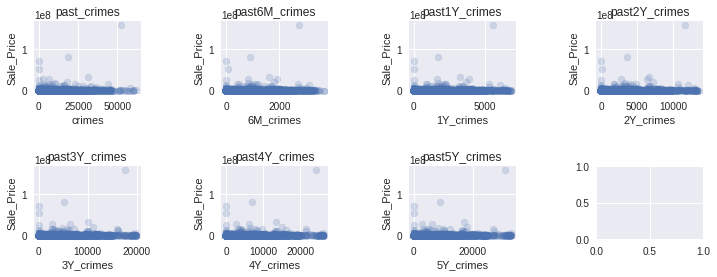

In [124]:
#Constructing scatter plots to visually identify the correlation between sale_price and 
#crime counts across various periods in the past

y = df_sales_sample['SALE PRICE']

fig, ax = plt.subplots(2,4,figsize=(12,4))
#for ax in axes:
x = df_sales_sample['past_crime_count']
ax[0,0].scatter(x, y,alpha=0.2)
ax[0,0].set_xlabel('crimes')
ax[0,0].set_ylabel('Sale_Price')
ax[0,0].set_title('past_crimes')
  
x = df_sales_sample['past6M_crime_count']
ax[0,1].scatter(x, y,alpha=0.2)
ax[0,1].set_xlabel('6M_crimes')
ax[0,1].set_ylabel('Sale_Price')
ax[0,1].set_title('past6M_crimes')

x = df_sales_sample['past1Y_crime_count']
ax[0,2].scatter(x, y,alpha=0.2)
ax[0,2].set_xlabel('1Y_crimes')
ax[0,2].set_ylabel('Sale_Price')
ax[0,2].set_title('past1Y_crimes')

x = df_sales_sample['past2Y_crime_count']
ax[0,3].scatter(x, y,alpha=0.2)
ax[0,3].set_xlabel('2Y_crimes')
ax[0,3].set_ylabel('Sale_Price')
ax[0,3].set_title('past2Y_crimes')

x = df_sales_sample['past3Y_crime_count']
ax[1,0].scatter(x, y,alpha=0.2)
ax[1,0].set_xlabel('3Y_crimes')
ax[1,0].set_ylabel('Sale_Price')
ax[1,0].set_title('past3Y_crimes')
  
x = df_sales_sample['past4Y_crime_count']
ax[1,1].scatter(x, y,alpha=0.2)
ax[1,1].set_xlabel('4Y_crimes')
ax[1,1].set_ylabel('Sale_Price')
ax[1,1].set_title('past4Y_crimes')

x = df_sales_sample['past5Y_crime_count']
ax[1,2].scatter(x, y,alpha=0.2)
ax[1,2].set_xlabel('5Y_crimes')b
ax[1,2].set_ylabel('Sale_Price')
ax[1,2].set_title('past5Y_crimes')

plt.subplots_adjust(wspace= 0.75, hspace = 1)

'Scatter Plots of Sale_Price Vs. Crime_count in various time periods'



In [127]:
#Performing Correlation tests for sale_price Vs. crime_counts
print('Pearson corellations coefficient for sale_price Vs. past_crme_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past_crime_count']))
print('\nPearson corellations coefficient for sale_price Vs. past6M_crme_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past6M_crime_count']))
print('\nPearson corellations coefficient for sale_price Vs. past1Y_crme_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past1Y_crime_count']))
print('\nPearson corellations coefficient for sale_price Vs. past2Y_crme_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past2Y_crime_count']))
print('\nPearson corellations coefficient for sale_price Vs. past3Y_crme_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past3Y_crime_count']))
print('\nPearson corellations coefficient for sale_price Vs. past4Y_crme_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past4Y_crime_count']))
print('\nPearson corellations coefficient for sale_price Vs. past4Y_crme_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past5Y_crime_count']))

Pearson corellations coefficient for sale_price Vs. past_crme_count: 
 (0.07816941224768377, 3.1211747435910972e-08)

Pearson corellations coefficient for sale_price Vs. past6M_crme_count: 
 (0.046070225174434487, 0.0011197425812773693)

Pearson corellations coefficient for sale_price Vs. past1Y_crme_count: 
 (0.048203420912197738, 0.00065051934558281151)

Pearson corellations coefficient for sale_price Vs. past2Y_crme_count: 
 (0.053354295086333117, 0.00016035235090022717)

Pearson corellations coefficient for sale_price Vs. past3Y_crme_count: 
 (0.055531203146109702, 8.5406737100808465e-05)

Pearson corellations coefficient for sale_price Vs. past4Y_crme_count: 
 (0.05894547171791463, 3.0372047179146179e-05)

Pearson corellations coefficient for sale_price Vs. past4Y_crme_count: 
 (0.062687730941832193, 9.1668493023749251e-06)


*From Above scatter plots and correlation tests we can conclude that there is not much correlation between past crime and sales_price of a property.*

*Though, all p-values < 0.05, the test statistics( correlation coefficients) are very minimal which shows a weak correlation*

*Surprisingly, (though correlations coefficient is very low) Sale_Price is in positive correlation with crime_counts while I was expecting a negative correlaton."

*crime_count associated with each property_sale_transaction has been calculated based on the respective zip_codes.*

*Tried to investigate further if crime_counts at neighborhood level will reveal a strong relation with sale_price.
However, geo-coding APIs do not providing consistent information at neighborhood level. costly for computation.*

In [3]:
#reading house_sales with crime counts
df_sales_sample = pd.read_csv('df_sales_sample.csv')
df_sales_sample.head()


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,past_crime_count,past6M_crime_count,past1Y_crime_count,past2Y_crime_count,past3Y_crime_count,past4Y_crime_count,past5Y_crime_count
0,4,FLUSHING-NORTH,01 ONE FAMILY HOMES,1,6406,44,,C0,142-30 BOOTH MEMORIAL AVE,,...,A1,665000.0,2005-06-02,0,0,0,0,0,0,0
1,3,BEDFORD STUYVESANT,02 TWO FAMILY HOMES,1,1836,25,,B3,448 JEFFERSON AVENUE,,...,B3,600000.0,2005-10-12,0,0,0,0,0,0,0
2,1,UPPER EAST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1438,1209,,R4,340 EAST 64TH STREET,12J,...,R4,1830000.0,2008-05-16,2964,591,1219,2507,2964,2964,2964
3,1,MIDTOWN WEST,10 COOPS - ELEVATOR APARTMENTS,2,1030,29,,D4,"200 CENTRAL PARK SOUTH, 9L",,...,D4,330000.0,2005-04-26,0,0,0,0,0,0,0
4,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2,741,60,,C1,350 WEST 18TH STREET,,...,C1,10000000.0,2015-05-14,33281,1433,3155,6565,9994,13481,16755


In [5]:
#reading crime_data from local drive
df_crime = pd.read_csv('df_crime.csv')
df_crime.head()

/home/mahesh_yerra/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,zip_code
0,101109527,2015-12-31,23:45:00,2015-12-31,NaN,2015-12-31,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
1,163896203,2015-11-12,23:00:00,2015-11-13,NaN,2015-11-13,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
2,938500214,2015-09-23,18:30:00,2015-09-23,19:00:00,2015-09-24,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
3,861343822,2015-08-31,12:00:00,2015-08-31,13:00:00,2015-09-04,344,ASSAULT 3 & RELATED OFFENSES,114.0,OBSTR BREATH/CIRCUL,...,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456
4,375862763,2015-08-09,04:00:00,2015-08-09,NaN,2015-08-09,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,INSIDE,STREET,NaN,NaN,1007314,241257,40.828848,-73.916661,"(40.828848333, -73.916661142)",10456


In [25]:
#df_crime.OFNS_DESC.value_counts()
df_crime.LAW_CAT_CD.value_counts()
#print(df_crime.head().iloc[:,10:])
#df_crime.columns

MISDEMEANOR    3058480
FELONY         1652665
VIOLATION       673022
Name: LAW_CAT_CD, dtype: int64

In [35]:
#Functions for calculating crime count for each zip code for different periods in the past.

def past_MISDEMEANOR_count(date,zip_code):
    '''
    This function calculates the number of past MISDEMEANOR crimes from crime database
    reported at a given zip_code as of given date.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['RPT_DT']< date) & (df_crime['LAW_CAT_CD'] == 'MISDEMEANOR')])
    return x

def past_FELONY_count(date,zip_code):
    '''
    This function calculates the number of past FELONY crimes from crime database
    reported at a given zip_code as of given date.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['RPT_DT']< date) & (df_crime['LAW_CAT_CD'] == 'FELONY')])
    return x

def past_VIOLATION_count(date,zip_code):
    '''
    This function calculates the number of past VIOLATION crimes from crime database
    reported at a given zip_code as of given date.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['RPT_DT']< date) & (df_crime['LAW_CAT_CD'] == 'VIOLATION')])
    return x

def past6M_MISDEMEANOR_count(date,zip_code):
    '''
    This function calculates the number of past MISDEMEANOR crimes from crime database
    reported at a given zip_code in past 6 months from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'MISDEMEANOR') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(6,'M')))])
    return x

def past6M_FELONY_count(date,zip_code):
    '''
    This function calculates the number of past FELONY crimes from crime database
    reported at a given zip_code in past 6 months from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'FELONY') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(6,'M')))])
    return x

def past6M_VIOLATION_count(date,zip_code):
    '''
    This function calculates the number of past VIOLATION crimes from crime database
    reported at a given zip_code in past 6 months from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'VIOLATION') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(6,'M')))])
    return x

def past1Y_MISDEMEANOR_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 1 Year from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'MISDEMEANOR') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(1,'Y')))])
    return x

def past1Y_FELONY_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 1 Year from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'FELONY') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(1,'Y')))])
    return x

def past1Y_VIOLATION_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 1 Year from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'VIOLATION') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(1,'Y')))])
    return x

def past2Y_MISDEMEANOR_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 2 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'MISDEMEANOR') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(2,'Y')))])
    return x

def past2Y_FELONY_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 2 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'FELONY') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(2,'Y')))])
    return x

def past2Y_VIOLATION_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 2 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'VIOLATION') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(2,'Y')))])
    return x

def past3Y_MISDEMEANOR_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 3 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'MISDEMEANOR') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(3,'Y')))])
    return x

def past3Y_FELONY_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 3 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'FELONY') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(3,'Y')))])
    return x

def past3Y_VIOLATION_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 3 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'VIOLATION') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(3,'Y')))])
    return x

def past4Y_MISDEMEANOR_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 4 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'MISDEMEANOR') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(4,'Y')))])
    return x

def past4Y_FELONY_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 4 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'FELONY') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(4,'Y')))])
    return x

def past4Y_VIOLATION_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 4 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'VIOLATION') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(4,'Y')))])
    return x

def past5Y_MISDEMEANOR_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 5 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'MISDEMEANOR') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(5,'Y')))])
    return x

def past5Y_FELONY_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 5 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'FELONY') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(5,'Y')))])
    return x

def past5Y_VIOLATION_count(date,zip_code):
    '''
    This function calculates the number of past crimes from crime database
    reported at a given zip_code in past 5 Years from Sale_date of property.
    '''
    x = len(df_crime[(df_crime['zip_code'] == zip_code) & (df_crime['LAW_CAT_CD'] == 'VIOLATION') & 
                     ((df_crime['RPT_DT']< date)&(pd.to_datetime(df_crime['RPT_DT'])> pd.to_datetime(date)-np.timedelta64(5,'Y')))])
    return x



In [36]:
#testing function calls
print('MISDEMEANOR crime count as of sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past_MISDEMEANOR_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('FELONY crime count as of sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past_FELONY_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('VIOLATION crime count as of sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past_VIOLATION_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))

#testing function calls
print('MISDEMEANOR crime count for past 6 months from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past6M_MISDEMEANOR_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('FELONY crime count for past 6 months from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past6M_FELONY_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('VIOLATION crime count for past 6 months from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past6M_VIOLATION_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))

#testing function calls
print('MISDEMEANOR crime count for past 1 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past1Y_MISDEMEANOR_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('FELONY crime count for past 1 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past1Y_FELONY_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('VIOLATION crime count for past 1 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past1Y_VIOLATION_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))


#testing function calls
print('MISDEMEANOR crime count for past 2 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past2Y_MISDEMEANOR_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('FELONY crime count for past 2 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past2Y_FELONY_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('VIOLATION crime count for past 2 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past2Y_VIOLATION_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))

#testing function calls
print('MISDEMEANOR crime count for past 3 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past3Y_MISDEMEANOR_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('FELONY crime count for past 3 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past3Y_FELONY_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('VIOLATION crime count for past 3 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past3Y_VIOLATION_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))

#testing function calls
print('MISDEMEANOR crime count for past 4 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past4Y_MISDEMEANOR_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('FELONY crime count for past 4 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past4Y_FELONY_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('VIOLATION crime count for past 4 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past4Y_VIOLATION_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))

#testing function calls
print('MISDEMEANOR crime count for past 5 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past5Y_MISDEMEANOR_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('FELONY crime count for past 5 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past5Y_FELONY_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))
print('VIOLATION crime count for past 5 year from sale date for zip_code: %d =  %d'%(df_sales_sample['ZIP CODE'][2],past5Y_VIOLATION_count((df_sales_sample['SALE DATE'][2]),df_sales_sample['ZIP CODE'][2])))





MISDEMEANOR crime count as of sale date for zip_code: 10065 =  1656
FELONY crime count as of sale date for zip_code: 10065 =  1085
VIOLATION crime count as of sale date for zip_code: 10065 =  223
MISDEMEANOR crime count for past 6 months from sale date for zip_code: 10065 =  349
FELONY crime count for past 6 months from sale date for zip_code: 10065 =  211
VIOLATION crime count for past 6 months from sale date for zip_code: 10065 =  31
MISDEMEANOR crime count for past 1 year from sale date for zip_code: 10065 =  667
FELONY crime count for past 1 year from sale date for zip_code: 10065 =  464
VIOLATION crime count for past 1 year from sale date for zip_code: 10065 =  88
MISDEMEANOR crime count for past 2 year from sale date for zip_code: 10065 =  1430
FELONY crime count for past 2 year from sale date for zip_code: 10065 =  906
VIOLATION crime count for past 2 year from sale date for zip_code: 10065 =  171
MISDEMEANOR crime count for past 3 year from sale date for zip_code: 10065 =  1656

In [45]:
#Function calls to count MISDEMEANOR crime counts(past 6 months - life time counts) for each sale sample

df_sales_sample['past_MISDEMEANOR_count'] = df_sales_sample.apply(lambda row: past_MISDEMEANOR_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
df_sales_sample.head()

df_sales_sample['past6M_MISDEMEANOR_count'] = df_sales_sample.apply(lambda row: past6M_MISDEMEANOR_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
df_sales_sample.head()

df_sales_sample['past1Y_MISDEMEANOR_count'] = df_sales_sample.apply(lambda row: past1Y_MISDEMEANOR_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
df_sales_sample.head()

df_sales_sample['past2Y_MISDEMEANOR_count'] = df_sales_sample.apply(lambda row: past2Y_MISDEMEANOR_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
df_sales_sample.head()


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,past6M_crime_count,past1Y_crime_count,past2Y_crime_count,past3Y_crime_count,past4Y_crime_count,past5Y_crime_count,past_MISDEMEANOR_count,past6M_MISDEMEANOR_count,past1Y_MISDEMEANOR_count,past2Y_MISDEMEANOR_count
0,4,FLUSHING-NORTH,01 ONE FAMILY HOMES,1,6406,44,,C0,142-30 BOOTH MEMORIAL AVE,,...,0,0,0,0,0,0,0,0,0,0
1,3,BEDFORD STUYVESANT,02 TWO FAMILY HOMES,1,1836,25,,B3,448 JEFFERSON AVENUE,,...,0,0,0,0,0,0,0,0,0,0
2,1,UPPER EAST SIDE (59-79),13 CONDOS - ELEVATOR APARTMENTS,2,1438,1209,,R4,340 EAST 64TH STREET,12J,...,591,1219,2507,2964,2964,2964,1656,349,667,1430
3,1,MIDTOWN WEST,10 COOPS - ELEVATOR APARTMENTS,2,1030,29,,D4,"200 CENTRAL PARK SOUTH, 9L",,...,0,0,0,0,0,0,0,0,0,0
4,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2,741,60,,C1,350 WEST 18TH STREET,,...,1433,3155,6565,9994,13481,16755,18263,751,1690,3624


In [ ]:
'''
df_sales_sample['past3Y_MISDEMEANOR_count'] = df_sales_sample.apply(lambda row: past3Y_MISDEMEANOR_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
df_sales_sample.head()

df_sales_sample['past4Y_MISDEMEANOR_count'] = df_sales_sample.apply(lambda row: past4Y_MISDEMEANOR_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
df_sales_sample.head()

df_sales_sample['past5Y_MISDEMEANOR_count'] = df_sales_sample.apply(lambda row: past5Y_MISDEMEANOR_count(row['SALE DATE'],row['ZIP CODE']),axis=1)
df_sales_sample.head()
'''


In [48]:
#writing "sales_sample(n=5000) with crime counts related to each sale transation" to local drive.
df_sales_sample.to_csv('df_sales_sample.csv',index=False)

In [46]:
#Performing Correlation tests for sale_price Vs. MISDEMEANOR crime_counts
print('Pearson corellations coefficient for sale_price Vs. past_MISDEMEANOR_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past_MISDEMEANOR_count']))
print('\nPearson corellations coefficient for sale_price Vs. past6M_MISDEMEANOR_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past6M_MISDEMEANOR_count']))
print('\nPearson corellations coefficient for sale_price Vs. past1Y_MISDEMEANOR_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past1Y_MISDEMEANOR_count']))
print('\nPearson corellations coefficient for sale_price Vs. past2Y_MISDEMEANOR_count: \n',st.pearsonr(df_sales_sample['SALE PRICE'],df_sales_sample['past2Y_MISDEMEANOR_count']))


Pearson corellations coefficient for sale_price Vs. past_MISDEMEANOR_count: 
 (0.084170825142232786, 2.5090179173914582e-09)

Pearson corellations coefficient for sale_price Vs. past6M_MISDEMEANOR_count: 
 (0.051383602468247171, 0.00027812939062308917)

Pearson corellations coefficient for sale_price Vs. past1Y_MISDEMEANOR_count: 
 (0.053653521667352204, 0.00014724982030502287)

Pearson corellations coefficient for sale_price Vs. past2Y_MISDEMEANOR_count: 
 (0.059664291426342206, 2.4256495234199846e-05)


In [157]:
def date2epoch(sample):
    '''converting standard sale date to epoch date to run regression model, 
    input parameter sample is predictor_matrix'''
    temp = sample.copy()
    X = []
    for x in sample.iloc[:,9]:
        X.append(time.mktime(pd.datetime.strptime(x, "%Y-%m-%d").timetuple()))
    temp.iloc[:,9] = X
    return temp

**Modeling & Evaluation**

In [3]:
df_sales_sample = pd.read_csv('df_sales_sample.csv')


In [4]:
model_data = df_sales_sample.loc[:,["BOROUGH","TAX CLASS AT PRESENT","RESIDENTIAL UNITS","COMMERCIAL UNITS","TOTAL UNITS","LAND SQUARE FEET","GROSS SQUARE FEET","YEAR BUILT","TAX CLASS AT TIME OF SALE","SALE DATE","past_crime_count","past6M_crime_count","past1Y_crime_count","past2Y_crime_count","past3Y_crime_count","past4Y_crime_count","past5Y_crime_count","past_MISDEMEANOR_count","past6M_MISDEMEANOR_count","past1Y_MISDEMEANOR_count","past1Y_MISDEMEANOR_count","SALE PRICE"]]
model_data["SALE DATE"] = model_data["SALE DATE"].apply(lambda x:(time.mktime(pd.datetime.strptime(x, "%Y-%m-%d").timetuple())))
model_data.dropna().shape

/home/mahesh_yerra/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(5000, 22)

In [5]:
model_data = pd.get_dummies(model_data)
model_data.loc[0,:]


BOROUGH                      4.000000e+00
RESIDENTIAL UNITS            3.000000e+00
COMMERCIAL UNITS             0.000000e+00
TOTAL UNITS                  3.000000e+00
LAND SQUARE FEET             4.000000e+03
GROSS SQUARE FEET            3.381000e+03
YEAR BUILT                   2.005000e+03
TAX CLASS AT TIME OF SALE    1.000000e+00
SALE DATE                    1.117688e+09
past_crime_count             0.000000e+00
past6M_crime_count           0.000000e+00
past1Y_crime_count           0.000000e+00
past2Y_crime_count           0.000000e+00
past3Y_crime_count           0.000000e+00
past4Y_crime_count           0.000000e+00
past5Y_crime_count           0.000000e+00
past_MISDEMEANOR_count       0.000000e+00
past6M_MISDEMEANOR_count     0.000000e+00
past1Y_MISDEMEANOR_count     0.000000e+00
past1Y_MISDEMEANOR_count     0.000000e+00
SALE PRICE                   6.650000e+05
TAX CLASS AT PRESENT_        0.000000e+00
TAX CLASS AT PRESENT_1       1.000000e+00
TAX CLASS AT PRESENT_1A      0.000

In [6]:
#Splitting Train & Test data
X = model_data.drop("SALE PRICE",axis = 1).values
Y = model_data["SALE PRICE"].values
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state = 21)



cross_validation_scores:
 [-0.55658302 -1.68821341  0.02842311 -0.10841679 -0.6434693 ]

Average CV Score: -0.5936518814913394

predicting sale price for first 5 entries in Test Data: [ 783409.47771871  303235.16227727  737977.66856903  307240.8621878
  502287.93644653]

test accuracy: -0.07227330118947028


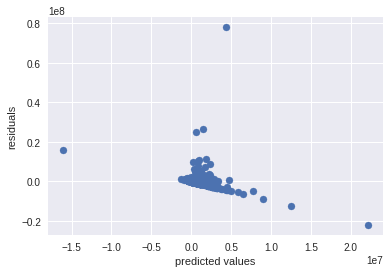

In [51]:
#Running Linear model
model = LinearRegression()
cv_scores = cross_val_score(model,x_train,y_train,cv = 5)
print("\ncross_validation_scores:\n",cv_scores)
print("\nAverage CV Score: {}".format(np.mean(cv_scores)))
model.fit(x_train,y_train)
print("\npredicting sale price for first 5 entries in Test Data:",model.predict(x_test[0:5]))
print("\ntest accuracy: {}".format(model.score(x_test,y_test)))

model_linear = model

#residual plot
residuals = y_test - model.predict(x_test)
fitted = model.predict(x_test)
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()


cross_validation_scores:
 [-0.59571466 -0.65618358  0.02244447 -0.01827594 -0.33362996]

Average CV Score: -0.31627193389154906

predicting sale price for first 5 entries in Test Data: [  763339.40874679   317710.71363052  1116367.13493461   831231.56052434
   473209.45414771]

test accuracy: -0.018406585445884804


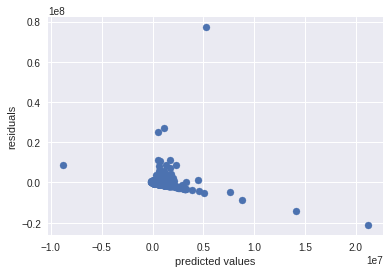

In [52]:
#running Ridge Regression
model = Ridge(alpha = 0.1,normalize = True)
cv_scores = cross_val_score(model,x_train,y_train,cv = 5)
print("\ncross_validation_scores:\n",cv_scores)
print("\nAverage CV Score: {}".format(np.mean(cv_scores)))
model.fit(x_train,y_train)
print("\npredicting sale price for first 5 entries in Test Data:",model.predict(x_test[0:5]))
print("\ntest accuracy: {}".format(model.score(x_test,y_test)))


model_ridge = model

#residual plot
residuals = y_test - model.predict(x_test)
fitted = model.predict(x_test)
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()


cross_validation_scores:
 [-0.67060839 -1.2603902   0.02184618 -0.04303577 -0.43446906]

Average CV Score: -0.47733144543158385

predicting sale price for first 5 entries in Test Data: [ 756882.81044224  259840.01518928  945822.70122705  684643.37179334
  490872.84165693]

test accuracy: -0.02938260061142306


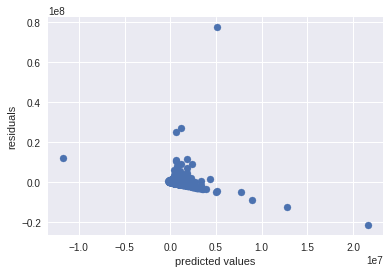

In [53]:
#running Lasso Regression
model = Lasso(alpha = 200,normalize = True)
cv_scores = cross_val_score(model,x_train,y_train,cv = 5)
print("\ncross_validation_scores:\n",cv_scores)
print("\nAverage CV Score: {}".format(np.mean(cv_scores)))
model.fit(x_train,y_train)
print("\npredicting sale price for first 5 entries in Test Data:",model.predict(x_test[0:5]))
print("\ntest accuracy: {}".format(model.score(x_test,y_test)))


model_lasso = model

#residual plot
residuals = y_test - model.predict(x_test)
fitted = model.predict(x_test)
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()

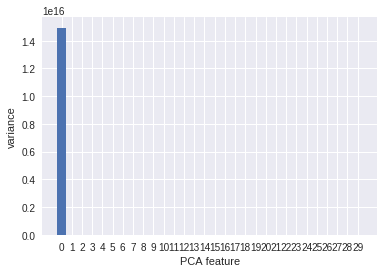


cross_validation_scores:
 [-0.00374809  0.00501888 -0.00070313 -0.00308592 -0.03010682]

Average CV Score: -0.006525014473941893

predicting sale price for first 5 entries in Test Data: [ 537224.67791604  383169.68295531  730923.86198522  799065.59088432
  402198.71714742]

test accuracy: 0.003700077731074836


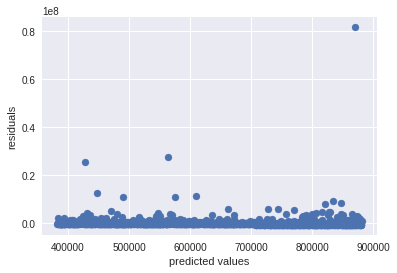

In [56]:
#running Linear model with PCA
# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
#pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
#pipeline.fit(samples)
pca.fit(x_train)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

model = LinearRegression()
pca = PCA(n_components = 1)
pca.fit(x_train)
pca_features = pca.transform(x_train)
#pipeline = Pipeline.make_pipeline(pca,model)
#pipeline.fit(x_train,y_train)
cv_scores = cross_val_score(model,pca_features,y_train,cv = 5)

print("\ncross_validation_scores:\n",cv_scores)
print("\nAverage CV Score: {}".format(np.mean(cv_scores)))
model.fit(pca_features,y_train)
print("\npredicting sale price for first 5 entries in Test Data:",model.predict(pca.transform(x_test[0:5])))
print("\ntest accuracy: {}".format(model.score(pca.transform(x_test),y_test)))

#residual plot
residuals = y_test - model.predict(pca.transform(x_test))
fitted = model.predict(pca.transform(x_test))
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()


best parameters: {'alpha': 10, 'normalize': 'True'}

best Score: 0.015160023300774487

predicting sale price for first 5 entries in Test Data: [ 784494.75267934  230923.75018918  707299.47554975  284581.47457718
  501556.18897387]

test accuracy: -0.07265676100572716


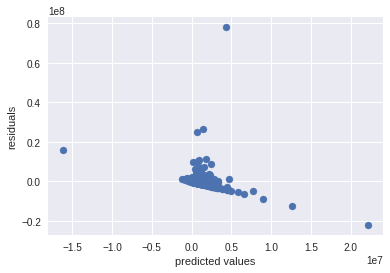

In [78]:
#running Ridge Regression with grid search
param_grid = {'alpha':[0.001,0.01,0.1,1,10,100],'normalize': ["True"]}
ridge = Ridge()
model = GridSearchCV(ridge,param_grid,cv=5)
#cv_scores = cross_val_score(model,x_train,y_train,cv = 5)
model.fit(x_train,y_train)
print("\nbest parameters: {}".format(model.best_params_))
print("\nbest Score: {}".format(model.best_score_))

params  = model.best_params_

ridge = Ridge(params['alpha'],params['normalize'])
ridge.fit(x_train, y_train)

print("\npredicting sale price for first 5 entries in Test Data:",ridge.predict(x_test[0:5]))
print("\ntest accuracy: {}".format(ridge.score(x_test,y_test)))


model = ridge

#residual plot
residuals = y_test - model.predict(x_test)
fitted = model.predict(x_test)
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()


In [79]:
model.coef_

array([ -2.13028750e+05,   3.89184894e+05,   1.39966865e+05,
        -3.56923122e+05,   5.53279832e+00,   1.90540922e+01,
         1.21535355e+02,   4.53557113e+05,   3.36696904e-04,
        -5.38504244e+02,   1.27344275e+03,  -5.11233392e+02,
         2.68498940e+02,  -3.02519172e+02,   2.25938375e+02,
        -1.63664350e+02,   1.06752054e+03,  -2.44292152e+03,
         3.50488148e+02,   3.50488148e+02,   8.93122978e+05,
         1.34893242e+05,   1.87141234e+05,   2.66616802e+05,
         9.66749639e+04,  -1.85562534e+05,  -1.80545309e+05,
        -7.45313777e+05,  -7.04698491e+04,  -3.96557751e+05])

training accuracy: 0.888780148814
test accuraccy: -0.906047147683
prediction: [ 1210219.    252642.     55899.7   339000.    139975.9]
actuals: [ 1389911.        0.        0.   666953.        0.]


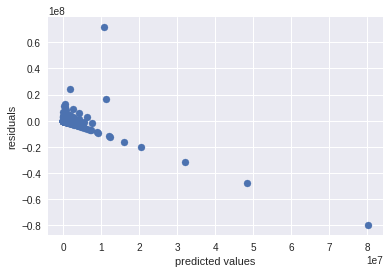

In [68]:
#running RandomForest regressor
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

print('training accuracy:',rf.score(x_train,y_train))
print('test accuraccy:',rf.score(x_test,y_test))
print('prediction:',rf.predict(x_test[0:5]))
print('actuals:',y_test[0:5])

model = rf
#residual plot
residuals = y_test - model.predict(x_test)
fitted = model.predict(x_test)
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()

In [34]:
print('prediction:',rf.predict(x_test[5:15]))
print('actuals:',y_test[5:15])

prediction: [  1.80670000e+03   2.36975000e+05   2.66100000e+05   3.10801900e+05
   2.60748480e+06   1.86600000e+05   2.82602000e+05   1.24400000e+05
   1.91000000e+05   6.14697500e+06]
actuals: [        0.         0.         0.    395000.  10033262.    155500.
    305000.         0.    789143.         0.]


In [32]:
rf.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=454409785, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=469746644, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1121975840, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_n

training accuracy: 0.913443635734
test accuraccy: -0.105272552429
prediction: [ 912443.2554992   277570.03243229  270133.28243737  970399.26583726
  260320.11181625]
actuals: [ 1389911.        0.        0.   666953.        0.]


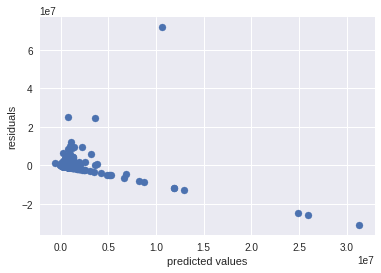

In [99]:
#running gradient boost
gbr = GradientBoostingRegressor()
gbr.fit(x_train,y_train)

print('training accuracy:',gbr.score(x_train,y_train))
print('test accuraccy:',gbr.score(x_test,y_test))
print('prediction:',gbr.predict(x_test[0:5]))
print('actuals:',y_test[0:5])

model = gbr

#residual plot
residuals = y_test - model.predict(x_test)
fitted = model.predict(x_test)
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()

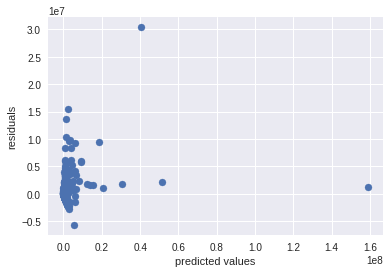

In [100]:
#residual plot
residuals = y_train - model.predict(x_train)
fitted = model.predict(x_train)
plt.scatter(fitted,residuals)
plt.xlabel("predicted values")
plt.ylabel("residuals")
plt.show()

In [80]:
help(model.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.linear_model.ridge.Ridge instance
    Returns the coefficient of determination R^2 of the prediction.
    
    The coefficient R^2 is defined as (1 - u/v), where u is the regression
    sum of squares ((y_true - y_pred) ** 2).sum() and v is the residual
    sum of squares ((y_true - y_true.mean()) ** 2).sum().
    Best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). A constant model that always
    predicts the expected value of y, disregarding the input features,
    would get a R^2 score of 0.0.
    
    Parameters
    ----------
    X : array-like, shape = (n_samples, n_features)
        Test samples.
    
    y : array-like, shape = (n_samples) or (n_samples, n_outputs)
        True values for X.
    
    sample_weight : array-like, shape = [n_samples], optional
        Sample weights.
    
    Returns
    -------
    score : float
        R